# Core Imports

In [85]:
!pip install update torch==2.0.1
!pip install torchtext==0.15.2
!pip install datasets==2.14.7
!pip install evaluate==0.4.0
!pip install torchvision==0.15.2

## Selecting the language pairs for training the translation model

In [86]:
! python3 -m spacy download en
! python3 -m spacy download es

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 84.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 75.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


## Library Imports

In [87]:
import os
import random
from tqdm.auto import tqdm
from dataclasses import dataclass

import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
import es_core_news_sm

import datasets
import torchtext

import torch
import torch.nn as nn
import torch.optim as optim

import evaluate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")

# Setting global varibles

In [88]:
# set random seed

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Data import and setup

In [89]:
def load_data(src_lang, target_lang):
    dataset_name = f"{src_lang}-{target_lang}"
    dataset = datasets.load_dataset("Helsinki-NLP/europarl", dataset_name, split="train[:3%]")

    return dataset

In [90]:
dataset = load_data('en', 'es')

In [91]:
dataset

Dataset({
    features: ['translation'],
    num_rows: 60272
})

In [92]:
def remove_translation_key(dataset):
    return dataset['translation']

dataset = dataset.map(remove_translation_key, remove_columns=["translation"])

In [93]:
dataset

Dataset({
    features: ['en', 'es'],
    num_rows: 60272
})

In [94]:
split_dataset = dataset.train_test_split(test_size=0.1, seed = seed)

train_dataset = split_dataset['train']
valid_dataset = split_dataset['test']

In [95]:
train_dataset[0]

{'en': 'A number of problems have already been raised by people such as the Belgian Police Federation, and there have been many documentaries in various countries about various games and the security arrangements for Euro 2000.',
 'es': 'Instituciones como la Federación de la Policía belga han señalado ya un cierto número de problemas, y, en varios países, se han emitido documentales sobre diferentes partidos y los dispositivos de seguridad para el Euro 2000.'}

In [96]:
with pd.option_context('display.max_colwidth', None):
    example_df = pd.DataFrame(train_dataset[:5])
    display(example_df)

,en,es
0,"A number of problems have already been raised by people such as the Belgian Police Federation, and there have been many documentaries in various countries about various games and the security arrangements for Euro 2000.","Instituciones como la Federación de la Policía belga han señalado ya un cierto número de problemas, y, en varios países, se han emitido documentales sobre diferentes partidos y los dispositivos de seguridad para el Euro 2000."
1,"Two other points I must make, because this is an essential question central to reform.","Debo formular otras dos observaciones, porque se trata de una cuestión esencial para la reforma."
2,"These numbers represent, in our opinion and in the opinion of the Council, a real improvement in terms of conservation in comparison with the level of 80% laid down in Council Regulation 685/95.","Estas cifras representan, a nuestro juicio y desde la perspectiva del Consejo, una mejora real desde el punto de vista de la conservación, si las comparamos con el nivel del 80% establecido en el Reglamento del Consejo 685/95."
3,It is therefore important that support for the type of body we are now talking about should be accompanied by special agreements concerning how the money is to be used and that there should be subsequent proficient monitoring of the quality of the operations concerned.,"Por eso es importante dar respaldo a los órganos del tipo al que nos estamos refiriendo, junto con acuerdos especiales sobre el manejo de los recursos y con evaluaciones de la calidad de las acciones."
4,"We wish you good luck, Mr President, and we thank you once again for coming here today and addressing us.","Buena suerte, señor Presidente, y le agradecemos de nuevo su presencia y su intervención."


In [97]:
en_nlp = en_core_web_sm.load()
es_nlp = es_core_news_sm.load()

In [98]:
def tokenize_example(    
    
    example,
    en_nlp,
    es_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    '''
    Tokenizes a textual English-Spanish input pair.    
    Args:
        example: (dict) a dictionary with one phrase in English and German; keys 'en', 'es'
        en_nlp: (spacy.lang) a spacy language model for English
        es_nlp: (spacy.lang) a spacy language model for Spanish
        max_length: (int) max input sentence length, symbols
        lower: (bool) if to lowercase input
        sos_token: (str) a start_of_sequence token
        eos_token: (str) an end_of_sequence token
    
    Return:    
        (dict) pre-processed and tokenized input sequence  
    '''
    en_tokens = [token.text for token in en_nlp.tokenizer(example['en'])][:max_length]
    es_tokens = [token.text for token in es_nlp.tokenizer(example['es'])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        es_tokens = [token.lower() for token in es_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    es_tokens = [sos_token] + es_tokens + [eos_token]
    return {"en_tokens": en_tokens, "es_tokens": es_tokens}

In [99]:
# Pre-process input data

max_length = 200
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp, 
    "es_nlp": es_nlp, 
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_dataset = train_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_dataset = valid_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/6028 [00:00<?, ? examples/s]

In [100]:
train_dataset

Dataset({
    features: ['en', 'es', 'en_tokens', 'es_tokens'],
    num_rows: 54244
})

In [101]:
# Creating vocab

min_freq = 2 # minimum frequency of occurrence in the text
unk_token = "<unk>" # unknown token
pad_token = "<pad>" # padding token

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

es_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["es_tokens"],
    min_freq=min_freq,
    specials=special_tokens,  
)

In [102]:
assert en_vocab[unk_token] == es_vocab[unk_token]
assert en_vocab[pad_token] == es_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(unk_index)
print(pad_index)

print(en_vocab['the'])

0
1
4


In [103]:
# Setting default value for oov words

en_vocab.set_default_index(unk_index)
es_vocab.set_default_index(unk_index)

In [104]:
def numericalize_example(example, en_vocab, es_vocab):
    '''
    Creates a mapping from string tokens to the vocabulary indexes.
    '''
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    es_ids = es_vocab.lookup_indices(example["es_tokens"])
    return {"en_ids": en_ids, "es_ids": es_ids}

In [105]:
fn_kwargs = {
    "en_vocab": en_vocab, 
    "es_vocab": es_vocab
}

train_dataset = train_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_dataset = valid_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/6028 [00:00<?, ? examples/s]

In [106]:
train_dataset[0]

{'en': 'A number of problems have already been raised by people such as the Belgian Police Federation, and there have been many documentaries in various countries about various games and the security arrangements for Euro 2000.',
 'es': 'Instituciones como la Federación de la Policía belga han señalado ya un cierto número de problemas, y, en varios países, se han emitido documentales sobre diferentes partidos y los dispositivos de seguridad para el Euro 2000.',
 'en_tokens': ['<sos>',
  'a',
  'number',
  'of',
  'problems',
  'have',
  'already',
  'been',
  'raised',
  'by',
  'people',
  'such',
  'as',
  'the',
  'belgian',
  'police',
  'federation',
  ',',
  'and',
  'there',
  'have',
  'been',
  'many',
  'documentaries',
  'in',
  'various',
  'countries',
  'about',
  'various',
  'games',
  'and',
  'the',
  'security',
  'arrangements',
  'for',
  'euro',
  '2000',
  '.',
  '<eos>'],
 'es_tokens': ['<sos>',
  'instituciones',
  'como',
  'la',
  'federación',
  'de',
  'la'

In [107]:
# Data to torch Dataset format

data_type = "torch"
format_columns = ["en_ids", "es_ids"]

train_dataset = train_dataset.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True
)

valid_dataset = valid_dataset.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

In [108]:
def get_collate_fn(pad_index):
    '''
    Adding padding as a part of a collate_fn.
    '''
    
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_es_ids = [example["es_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_es_ids = nn.utils.rnn.pad_sequence(batch_es_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "es_ids": batch_es_ids,
        }
        return batch
    
    return collate_fn

In [109]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    
    collate_fn = get_collate_fn(pad_index)
    
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [110]:
batch_size = 32

train_data_loader = get_data_loader(train_dataset, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_dataset, batch_size, pad_index)

In [111]:
next(iter(train_data_loader))

{'en_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [  15,   14,   14,  ...,   17,    4,   15],
         [  24, 1558, 6895,  ...,   35,   98,  307],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]]),
 'es_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [ 109,  148,   98,  ...,   23,    6,  580],
         [  55, 1966, 6431,  ...,   72,   26,   12],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]])}

In [112]:
batch = next(iter(train_data_loader))
print("EN IDs", batch["en_ids"].max())
print("ES IDs :", batch["es_ids"].max())

EN IDs tensor(14165)
ES IDs : tensor(21806)


# Building models

In [113]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, src): # (src_length, batch size)
        
        embedded = self.dropout(self.embedding(src)) # (src_length, batch_size, embedding_dim)

        outputs, hidden = self.rnn(embedded)
        # outputs (src_length, batch_size, hidden dim * n_directions)
        # hidden (n_layers * n_directions, batch_size, hidden dim)
        
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        
        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN 
        # hidden [-1, :, : ] is the last of the backwards RNN
       
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        # outputs (src_length, batch_size, encoder_hidden_dim * 2)
        # hidden (batch_size, decoder_hidden_dim)
        
        return outputs, hidden

In [114]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, 
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):        
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)
        
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1) # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch_size, src_length, encoder_hidden_dim * 2)
        
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2))) 
        # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2) # batch_size, src_length

        return torch.softmax(attention, dim=1)

In [115]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim) 
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, 
            output_dim
        )
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, input, hidden, encoder_outputs):
        # input = (batch_size)
        # hidden = batch_size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs) # batch matrix-matrix product
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [116]:
input_dim = len(es_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 128
decoder_embedding_dim = 128
encoder_hidden_dim = 256
decoder_hidden_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = '/kaggle/working'

## Seq2Seq model

In [117]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [118]:
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
)


model = Seq2Seq(encoder, decoder, device).to(device)

model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(22675, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(14827, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=14827, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [119]:
def init_weights(m):
    """
    Initiates model weights from the normal distribution.
    Sets bias to 0.
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(22675, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(14827, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=14827, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

## RNN/LSTM/GRU model

# Outlining the Loss and Optimizer functions

In [120]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [121]:
torch.cuda.empty_cache()

# Training the model

In [122]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(data_loader)):
        src = batch["es_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        torch.cuda.empty_cache()
    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["es_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0) #turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [123]:
n_epochs = 5
clip = 1.0 # gradient clipping
teacher_forcing_ratio = 0.5
train_losses = []
val_losses = []
best_valid_loss = float("inf")

for epoch in tqdm(range(n_epochs)):
        
    train_loss = train_fn(
        model, 
        train_data_loader, 
        optimizer, 
        criterion, 
        clip, 
        teacher_forcing_ratio, 
        device,
    )
    
    train_losses.append(train_loss)
    
    valid_loss = evaluate_fn(
        model, 
        valid_data_loader, 
        criterion, 
        device,
    )
    
    val_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'en_es.pt'))
    
    print(f"\tTrain Loss: {train_loss:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

	Train Loss:   5.548
	Valid Loss:   5.685


0it [00:00, ?it/s]

	Train Loss:   4.611
	Valid Loss:   5.389


0it [00:00, ?it/s]

	Train Loss:   4.047
	Valid Loss:   5.210


0it [00:00, ?it/s]

	Train Loss:   3.691
	Valid Loss:   5.200


0it [00:00, ?it/s]

	Train Loss:   3.434
	Valid Loss:   5.192


# Visualising results

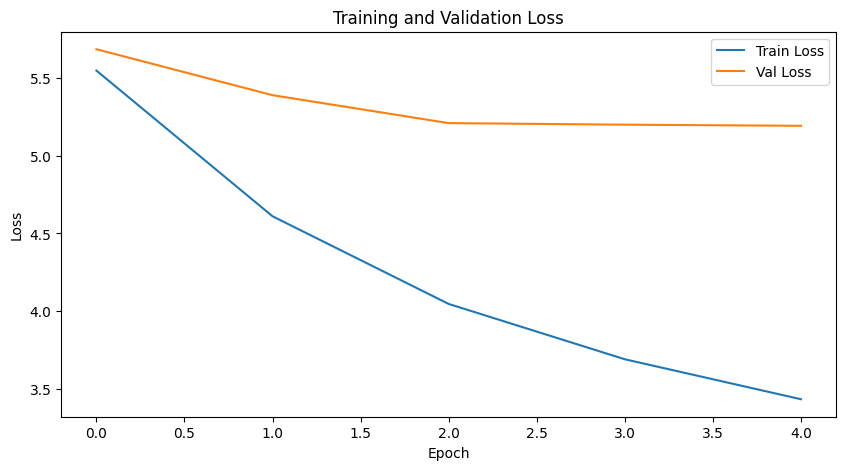

In [124]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Translation example

In [125]:
def translate_sentence(
    sentence, 
    model,
    en_nlp,
    es_nlp,
    en_vocab,
    es_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            es_tokens = [token.text for token in es_nlp.tokenizer(sentence)]
        else:
            es_tokens = [token for token in sentence]
        if lower:
            es_tokens = [token.lower() for token in es_tokens]
        es_tokens = [sos_token] + es_tokens + [eos_token]
        ids = es_vocab.lookup_indices(es_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, es_tokens, attentions[:len(en_tokens)-1]

In [147]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10,10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [138]:
def visualise_performance(num):
    sentence = valid_dataset[num]["es"]
    expected_translation = valid_dataset[num]["en"]

    print(' --- Sentences --- ')
    print(sentence)
    print()
    print(expected_translation)
    print()

    translation, sentence_tokens, attention = translate_sentence(
        sentence,
        model,
        en_nlp,
        es_nlp,
        en_vocab,
        es_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )

    print(' --- Tokens --- ')
    print(translation)
    print()
    print(sentence_tokens)
    print()

    plot_attention(sentence_tokens, translation, attention)

 --- Sentences --- 
Su Señoría ha de ser consciente, en primer lugar, de la dificultad existente en el nivel de la selección de los objetivos en una acción militar, en particular cuando se hace con medios aéreos, y también de que hay un conjunto de objetivos, no de carácter militar, sino infraestructural, encaminados a obstaculizar el funcionamiento de la maquinaria militar.

Mr Marset Campos, you will be aware, first of all, of how difficult it is to select targets during a military operation, particularly an air-based one, and you will also be aware that there is a category of targets that, whilst they are not military targets as such, are infrastructure targets selected with a view to hindering the smooth running of the military machine.

 --- Tokens --- 
['<sos>', 'honourable', 'honourable', 'member', 'state', 'must', 'be', 'aware', 'of', 'the', 'difficulty', 'in', 'the', 'the', 'of', 'the', 'the', 'military', 'action', ',', 'particularly', 'when', 'it', 'is', 'needed', ',']

['<so

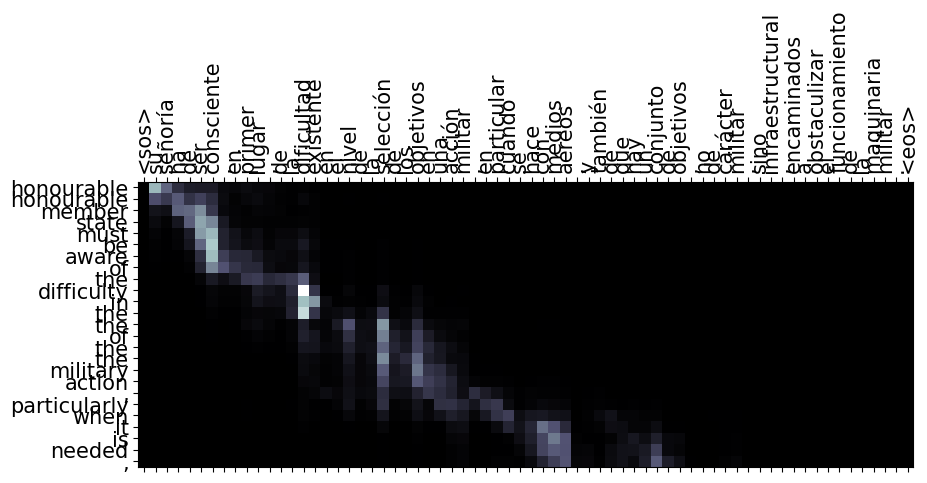

In [148]:
visualise_performance(0)

 --- Sentences --- 
Esto no constituye, sin embargo, de ningún modo un motivo para que la Comisión pueda darse por satisfecha.

However, this gives the Commission no cause whatsoever for complacency.

 --- Tokens --- 
['<sos>', 'this', 'is', 'not', 'a', 'case', 'of', 'the', 'commission', 'can', 'therefore', 'be', 'able', 'to', 'be', '.', '.', '<eos>']

['<sos>', 'esto', 'no', 'constituye', ',', 'sin', 'embargo', ',', 'de', 'ningún', 'modo', 'un', 'motivo', 'para', 'que', 'la', 'comisión', 'pueda', 'darse', 'por', 'satisfecha', '.', '<eos>']



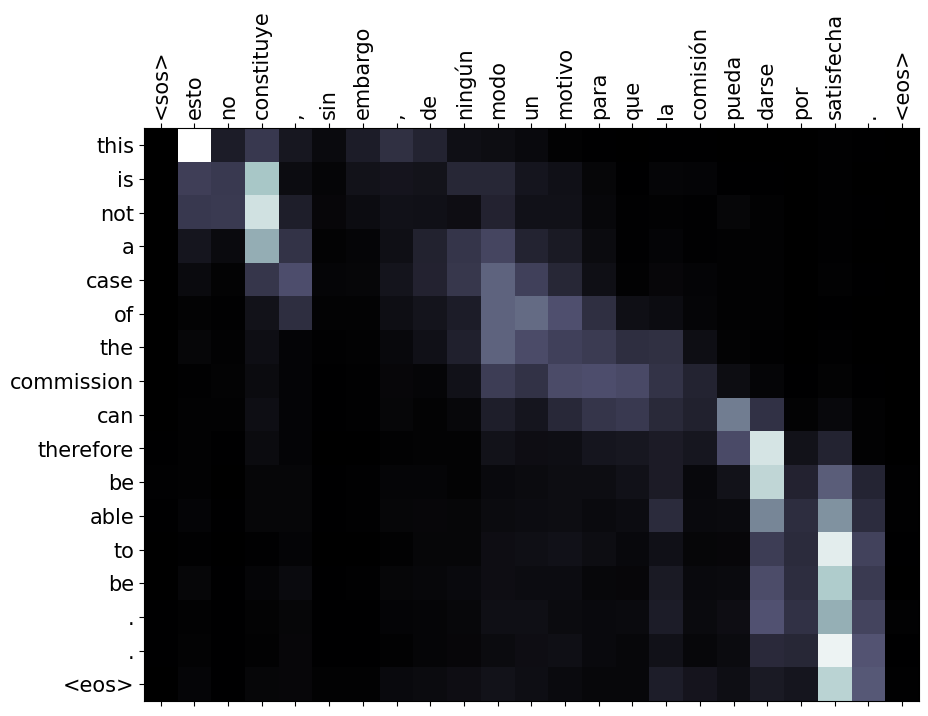

In [149]:
visualise_performance(5)

 --- Sentences --- 
Por lo visto eso no es suficiente.

But this apparently is not enough.

 --- Tokens --- 
['<sos>', 'this', 'is', 'not', 'enough', 'enough', '.', '<eos>']

['<sos>', 'por', 'lo', 'visto', 'eso', 'no', 'es', 'suficiente', '.', '<eos>']



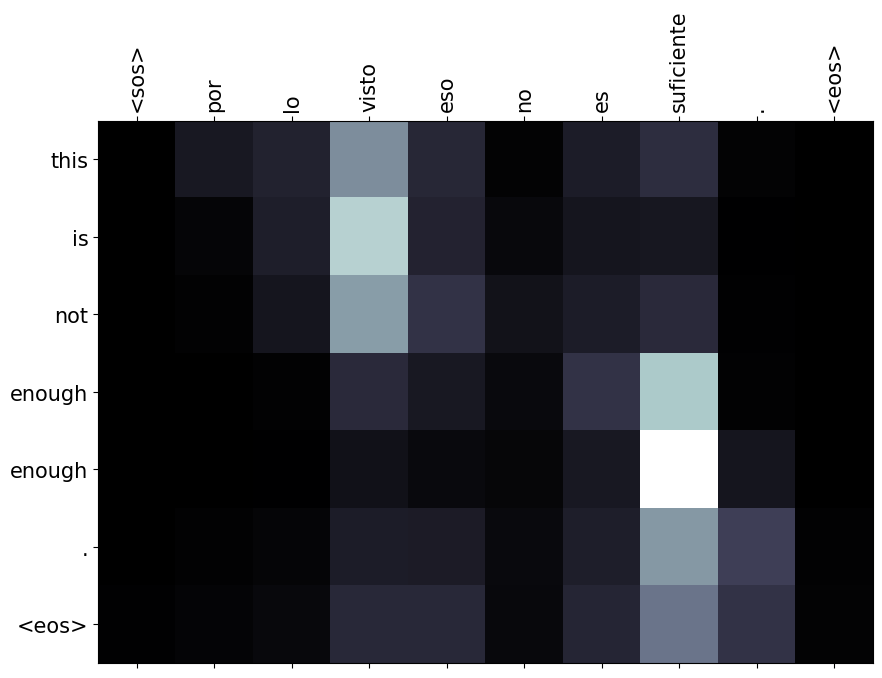

In [150]:
visualise_performance(11)

# Analysis

Overall the performance of the Seq2Seq model is quite good based on the data output tests. The training was on 5 epochs and the training was performed on only 3% of the Helsinki-NLP/europarl dataset. This decision of only using a small amount of the whole Helsinki-NLP en-es dataset. This was in order to allow for the model to train properly using only one P100 GPU that is available on Kaggle and to make the most of the time availability. However, despite these limitations in the amount of epochs and the size of the dataset, the model performed quite well as is seen by the above examples and visualisations. The model performed quite well on the smaller as well as the longer sentences with slight visual superiority evident in the graphs of the smaller sentences that had quite equal lengths of the input and output sentences. 

The further improvements on this model can be in the area of using a larger amount of the dataset for training and to also use more epochs. This will of course increase the amount of time that is required for the training of the model; however, it will most likely also result in more iterations given to the training that would hopefully result in further and more pronounced decreases of the training and actual loss curves.